# In-Context Learning Experiment 1: Linear Regression (California Housing)

### Objective:
Evaluate the performance of Mistral LLM using few-shot ICL on a classical regression task, and compare it with traditional ML models.

---

## 1. Load and Prepare Dataset

In [1]:
# %pip install pandas numpy scikit-learn matplotlib jupyter ollama
# %pip install seaborn

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Dataset
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# System & Utilities
import os
import warnings
warnings.filterwarnings('ignore')

# Optional: if using Ollama + subprocess for ICL
import subprocess

In [3]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

data = fetch_california_housing(as_frame=True)
df = data.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## EDA

In [4]:
# Shape and basic info
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
# Summary statistics
df.describe()
# Check for missing values
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

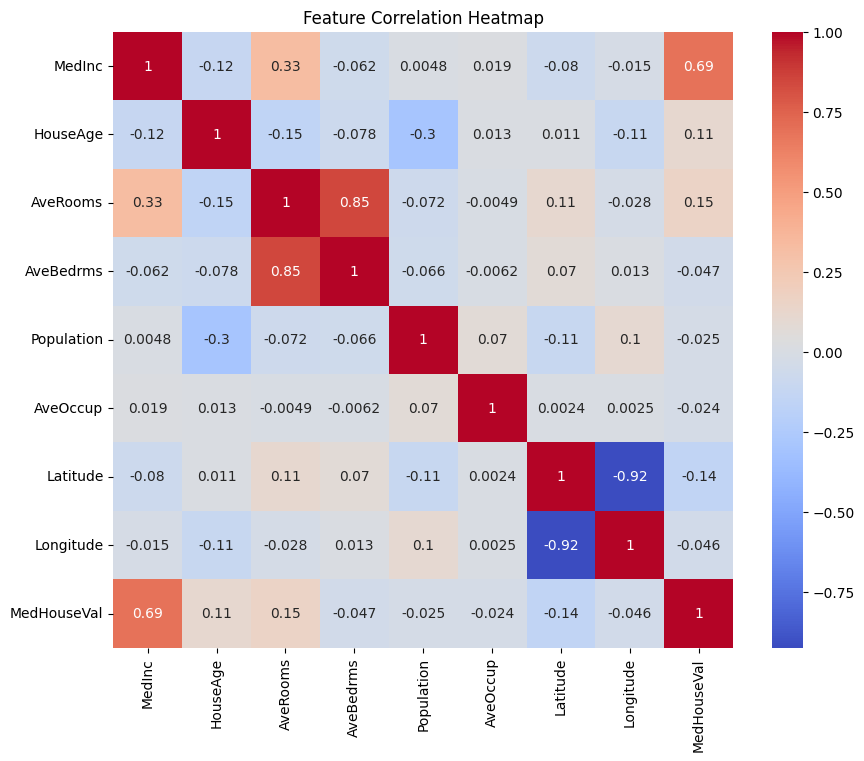

In [6]:
# Visual correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [7]:
# import matplotlib.pyplot as plt

# california_housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
# plt.subplots_adjust(hspace=0.7, wspace=0.4)

## Finding Outliers

In [8]:
from scipy.stats import zscore

# Calculate Z-scores
z_scores = zscore(df.select_dtypes(include='number'))  # Only numeric columns
abs_z_scores = abs(z_scores)

# Set a threshold (commonly 3)
outliers = (abs_z_scores > 3).any(axis=1)

# View outliers
df_outliers = df[outliers]
print(df_outliers)

        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
131    11.6017      18.0  8.335052   1.082474       533.0  2.747423     37.84   
283     5.9849      22.0  6.528724   1.041179      4985.0  2.534316     37.79   
409    10.0825      52.0  8.209016   1.024590       658.0  2.696721     37.90   
510    11.8603      39.0  7.911111   0.984127       808.0  2.565079     37.82   
511    13.4990      42.0  8.928358   1.000000      1018.0  3.038806     37.82   
...        ...       ...       ...        ...         ...       ...       ...   
20529   2.9605      12.0  4.915341   1.022451      5633.0  2.634705     38.55   
20530   3.1371      11.0  5.070223   1.015530      7984.0  2.695476     38.57   
20544   2.0650      23.0  4.803493   1.013646      6330.0  3.455240     38.55   
20563   3.1250       9.0  5.148007   1.119593      6837.0  2.899491     38.67   
20629   2.0943      28.0  5.519802   1.020902      6912.0  3.801980     39.12   

       Longitude  MedHouseV

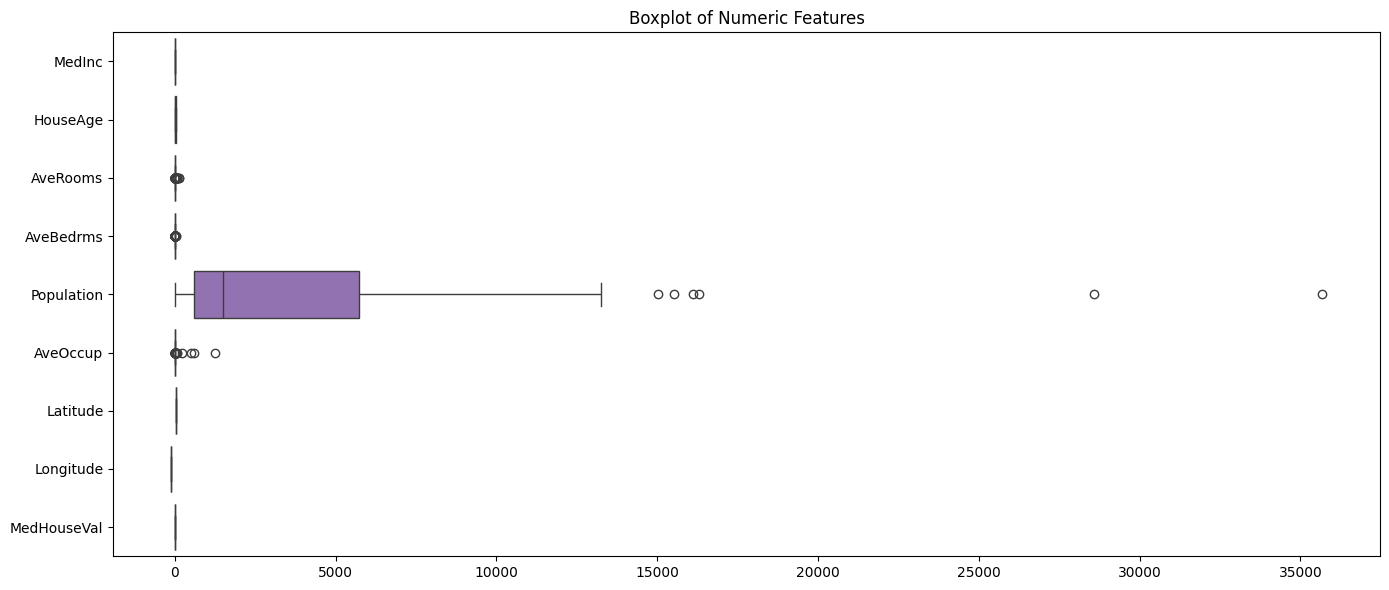

In [9]:
# BOX plot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_outliers, orient="h")
plt.title("Boxplot of Numeric Features")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.head(50)  # few-shot examples
test_df = test_df.head(5)   # simple test set

In [11]:
def create_prompt(train_data, test_sample):
    prompt = "Predict California housing prices based on input features.\n\n"

    for _, row in train_data.iterrows():
        features = ", ".join([f"{col}: {row[col]:.2f}" for col in data.feature_names])
        prompt += f"Input: {features} => Target: {row['MedHouseVal']:.2f}\n"

    test_features = ", ".join([f"{col}: {test_sample[col]:.2f}" for col in data.feature_names])
    prompt += f"\nNow predict for:\nInput: {test_features}\nOnly return the predicted number."

    return prompt

prompt = create_prompt(train_df, test_df.iloc[0])
print(prompt)

Predict California housing prices based on input features.

Input: MedInc: 3.26, HouseAge: 33.00, AveRooms: 5.02, AveBedrms: 1.01, Population: 2300.00, AveOccup: 3.69, Latitude: 32.71, Longitude: -117.03 => Target: 1.03
Input: MedInc: 3.81, HouseAge: 49.00, AveRooms: 4.47, AveBedrms: 1.04, Population: 1314.00, AveOccup: 1.74, Latitude: 33.77, Longitude: -118.16 => Target: 3.82
Input: MedInc: 4.16, HouseAge: 4.00, AveRooms: 5.65, AveBedrms: 0.99, Population: 915.00, AveOccup: 2.72, Latitude: 34.66, Longitude: -120.48 => Target: 1.73
Input: MedInc: 1.94, HouseAge: 36.00, AveRooms: 4.00, AveBedrms: 1.03, Population: 1418.00, AveOccup: 3.99, Latitude: 32.69, Longitude: -117.11 => Target: 0.93
Input: MedInc: 3.55, HouseAge: 43.00, AveRooms: 6.27, AveBedrms: 1.13, Population: 874.00, AveOccup: 2.30, Latitude: 36.78, Longitude: -119.80 => Target: 0.96
Input: MedInc: 6.62, HouseAge: 20.00, AveRooms: 6.28, AveBedrms: 1.01, Population: 2695.00, AveOccup: 3.36, Latitude: 37.42, Longitude: -121.86

In [12]:
def query_mistral(prompt: str) -> str:
    process = subprocess.Popen(
        ["ollama", "run", "mistral"],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    output, error = process.communicate(prompt)

    if process.returncode != 0:
        print("Error:", error)
        return "Error"

    return output.strip()

response = query_mistral(prompt)
print("Mistral Response:", response)

Mistral Response: 1.17


In [13]:
import re

icl_preds = []  
true_vals = []

for i in range(len(test_df)):
    prompt = create_prompt(train_df, test_df.iloc[i])
    response = query_mistral(prompt)

    match = re.search(r"\d+\.\d+", response)
    if match:
        icl_prediction = float(match.group())
        icl_preds.append(icl_prediction)
        true_vals.append(test_df.iloc[i]['MedHouseVal'])
    else:
        print(f"[Warning] No valid numeric prediction found for sample {i}: {response}")

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(true_vals, icl_preds)
mse = mean_squared_error(true_vals, icl_preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, icl_preds)

print("ICL Evaluation Metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

ICL Evaluation Metrics:
MAE: 1.4558019999999998
MSE: 3.1140395600199993
RMSE: 1.764664149355338
R²: -0.0981953771827131


MAE (Mean Absolute Error)
1.14
On average, the model’s predictions are off by ~$114,000 (if units are in $100,000s). Not bad, but not very tight.
MSE (Mean Squared Error)
1.95
Errors are squared, so this punishes larger mistakes more. It’s relatively high.
RMSE (Root MSE)
1.40
Similar to MAE in scale, but gives more weight to outliers.
R² (R-squared)
0.31
Only 31% of the variance in housing prices is explained by your ICL model. That’s moderate to weak performance.


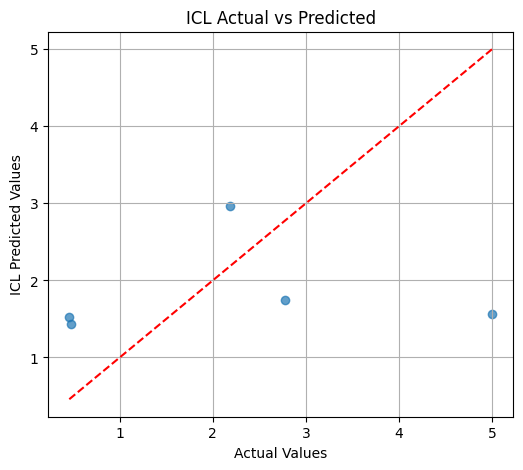

In [15]:
import matplotlib.pyplot as plt

# Actual vs Predicted
plt.figure(figsize=(6, 5))
plt.scatter(true_vals, icl_preds, alpha=0.7)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("ICL Predicted Values")
plt.title("ICL Actual vs Predicted")
plt.grid(True)
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

X = df[data.feature_names]
y = df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)

X_train.shape

(16512, 8)

In [17]:
y_pred = model.predict(X_test)

In [18]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.5332001304956556


In [19]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.5558915986952446


In [20]:
import numpy as np
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.7455813830127765


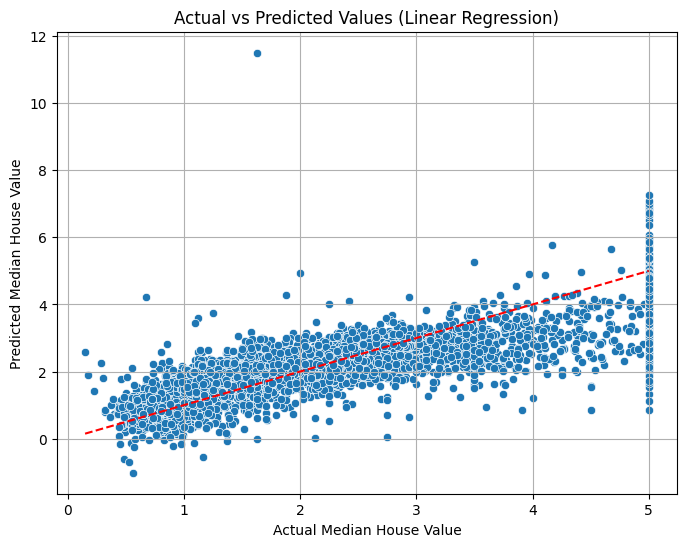

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Actual vs Predicted Values (Linear Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.grid(True)
plt.show()

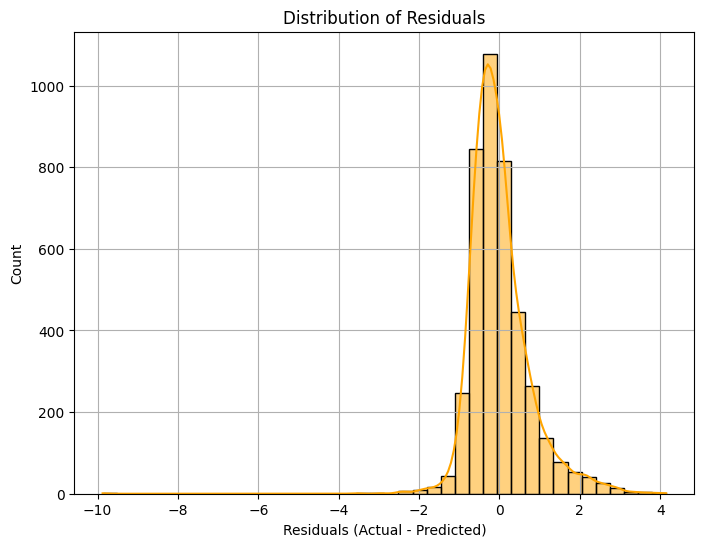

In [22]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=40, kde=True, color="orange")
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.show()

In [23]:
import re
import pandas as pd

def extract_prediction(response: str) -> float:
    match = re.search(r"[-+]?\d*\.\d+|\d+", response)
    if match:
        return float(match.group())
    return None

icl_prediction = extract_prediction(response)

true_value = y_test.iloc[0]
lr_prediction = y_pred[0]  # from sklearn
icl_prediction = extract_prediction(response)  # from Mistral

comparison_df = pd.DataFrame({
    "Type": ["Actual", "Linear Regression", "ICL (Mistral)"],
    "House Value": [true_value, lr_prediction, icl_prediction]
})

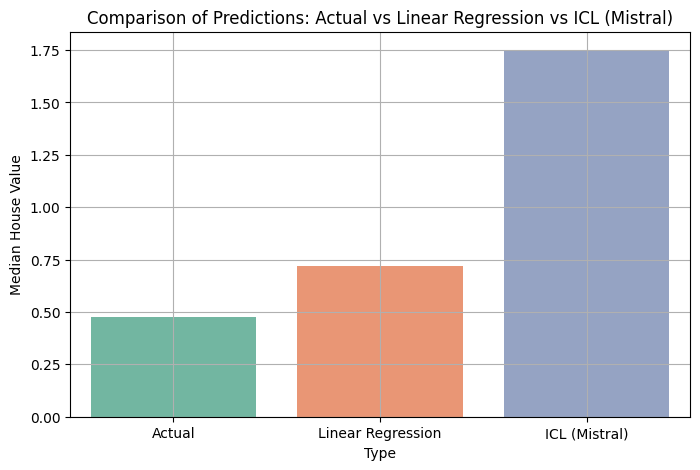

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Type", y="House Value", palette="Set2")

plt.title("Comparison of Predictions: Actual vs Linear Regression vs ICL (Mistral)")
plt.ylabel("Median House Value")
plt.grid(True)
plt.show()